In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2gray

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc
# import the modules
import os
from os import listdir
 

import shutil
import warnings


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import svm
from sklearn.metrics import confusion_matrix, f1_score, precision_score, \
                            recall_score, accuracy_score, classification_report

import seaborn as sns; sns.set()

from skimage import io, exposure, morphology, filters, color, \
                    segmentation, feature, measure, img_as_float, img_as_ubyte
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
warnings.simplefilter("ignore")
from scipy import ndimage as ndi

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, \
                         Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import Callback


In [92]:
labels = pd.read_csv("images/ISIC_2018/metadata.csv", index_col=0)

labels.head()



# Define the input and output CSV file paths

output_file = 'output.csv'

# Define the criteria for lines to keep (e.g., a condition)

folder_dir = "photos"

images_names=[]

for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            images_names.append(img_id[:-4])

# Read the input CSV file and filter the lines to keep
lines_to_keep = []
#print(images_names)
with open("images/ISIC_2018/metadata.csv", 'r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Read the header row (if exists)
    for row in reader:
        for i in range(len(images_names)):
            #print(row[0]+" et "+images_names[i])
            if str(row[0]) == images_names[i]:
                lines_to_keep.append(row)

     

# Write the filtered lines to the output CSV file
with open(output_file, 'w', newline='') as file:
    writer = csv.writer(file)
    #writer.writerow(header)
    lines_to_keep= [header]+lines_to_keep  
    writer.writerows(lines_to_keep)


In [16]:
def image_show(image, size=None, cmap=None, no_axis=True):

    if size is None:
        size = plt.rcParams['figure.figsize']
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=size)
    ax.grid(False)
    if cmap is not None:
        ax.imshow(image, cmap=cmap)
    else:
        ax.imshow(image)
    if no_axis:
        ax.axis('off')
    return fig, ax

In [3]:
structuring_element = morphology.disk(7)

@adapt_rgb(each_channel)
def morph_closing_each(image, struct_element):
    return morphology.closing(image, struct_element)


@adapt_rgb(hsv_value)
def morph_closing_hsv(image, struct_element):
    return morphology.closing(image, struct_element)

In [20]:
@adapt_rgb(each_channel)
def median_filter_each(image, struct_element):
    return filters.median(image, struct_element)


@adapt_rgb(hsv_value)
def median_filter_hsv(image, struct_element):
    return filters.median(image, struct_element)

In [129]:
def preprocessing(image_path):
        # 1) Equalize the image contrast using  the Contrast-Limited Adaptive 
        #    Histogram Equalization (CLAHE) method.
        
        image = io.imread(image_path)
        # convert the original image into grayscale
        equalized_adapthist = exposure.equalize_adapthist(image)
        #image_show( equalized_adapthist, size=None, cmap=None, no_axis=True)
        # 2) Use morphological closing to remove hairs (in order to simulate the Razor filter).
        #    Images are processed using the 'morph_closing_each()' function which applies
        #    the morphological closing to each channel of the RGB image.
        img_morph_closing = morph_closing_each(equalized_adapthist, structuring_element)
        #image_show( img_morph_closing, size=None, cmap=None, no_axis=True)
        # 3) Use the median filter to apply interpolation on the obtained image.
        #    The median filter is implemented using the 'median_filter_each()'
        #    function which pass each of the RGB channels to the median filter
        #    one-by-one, and stitch the results back into an RGB image.
        img_filtered = median_filter_each(img_morph_closing, structuring_element)
        #image_show(img_filtered , size=None, cmap=None, no_axis=True)
        # save the final processed image
        io.imsave(image_path,img_filtered )
        
preprocessing("burk.jpg")

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [37]:
def images_segmentation(image_path):
        image = io.imread(image_path)
        # convert the original image into grayscale
        gray_img = color.rgb2gray(image)
        #image_show(gray_img, size=None, cmap=None, no_axis=True)
        # 1] Apply Sobel filter
        elevation_map = filters.sobel(gray_img)
        #image_show(elevation_map, size=None, cmap=None, no_axis=True)
        # 2] Build image markers using the threshold obtained through the ISODATA filter
        markers = np.zeros_like(gray_img)
        threshold = filters.threshold_isodata(gray_img)
        markers[gray_img > threshold] = 1
        markers[gray_img < threshold] = 2
        # 3] Apply Wathershed algorithm in order to segment the image filtered
        #    using the markers
        segmented_img = morphology.watershed(elevation_map, markers)
        #image_show(segmented_img, size=None, cmap=None, no_axis=True)

        # 4] Improve segmantation:
        #    >  Fill small holes 
        segmented_img = ndi.binary_fill_holes(segmented_img - 1)
        #    > Remove small objects that have an area less than 800 px:
        #      this could be useful to exclude some regions that does not represent a lesion
        segmented_img = morphology.remove_small_objects(segmented_img, min_size=800)
        #image_show(segmented_img, size=None, cmap=None, no_axis=True)

        #    > Clear regions connected to the image borders.
        #      This operation is very useful when there are contour regions have a
        #      big area and so they can be exchanged with the lesion.
        #      However, this can also create some issues when the lesion region is
        #      connected to the image borders. In order to (try to) overcome this
        #      issue, we use a lesion identification algorithm (see below)
        img_border_cleared = segmentation.clear_border(segmented_img)
        # 5] Apply connected components labeling algorithm:
        #    it assigns labels to a pixel such that adjacent pixels of the same
        #    features are assigned the same label.
        # labeled_img, _ = ndi.label(segmented_img)
        labeled_img = morphology.label(img_border_cleared)
        
        # 6] Lesion identification algorithm:
        # Compute properties of labeled image regions:
        # it will be used to automatically select the region that contains
        # the skin lesion according to area and extent
        props = measure.regionprops(labeled_img)
        # num labels -> num regions
        num_labels = len(props)
        # Get all the area of detected regions
        areas = [region.area for region in props]

        if num_labels > 0 and areas[np.argmax(areas)] >= 1200:
            target_label = props[np.argmax(areas)].label
        else:
           
            labeled_img = morphology.label(segmented_img)
            # Get new region properties
            props = measure.regionprops(labeled_img)
            # Get the new list of areas
            areas = [region.area for region in props]
            # List of regions' extent.
            # Each extent is defined as the ratio of pixels in the region  to pixels
            # in the total bounding box (computed as: area / (rows * cols))
            extents = [region.extent for region in props]
            
            # Get the index of the region having the largest area and if there are
            # more than one or two regions, find also the index of the second and
            # third most largest regions.
            region_max1 = np.argmax(areas)
            if len(props) > 1:
                areas_copy = areas.copy()
                areas_copy[region_max1] = 0
                region_max2 = np.argmax(areas_copy)
            if len(props) > 2:
                areas_copy[region_max2] = 0
                region_max3 = np.argmax(areas_copy)

            # If the largest region has an extent greater than 0.50, it is our target region
            if extents[region_max1] > 0.50:
                target_label = props[region_max1].label
            # ... else check if the extent of the second largest region is greater than 0.5,
            # and if so we have found our target region
            elif len(props) > 1 and extents[region_max2] > 0.50:
                target_label = props[region_max2].label
            # ... else if the third largest region has an extent greater than 0.50,
            # it is (more probably) the one containing the lesion
            elif len(props) > 2 and extents[region_max3] > 0.50:
                target_label = props[region_max3].label
            # ... otherwise we choose the largest region
            else:
                target_label = props[region_max1].label

        for row, col in np.ndindex(labeled_img.shape):
            if labeled_img[row, col] != target_label:
                labeled_img[row, col] = 0
        # Convert the labeled image into its RGB version
        image_label_overlay = color.label2rgb(labeled_img, gray_img)
        #image_show(image_label_overlay, size=None, cmap=None, no_axis=True)

        io.imsave(image_path,  image_label_overlay)
        return props[target_label - 1]

In [41]:
def features_extraction(image_path,dictionnaire):

    feature_list=[]
    image = io.imread(image_path)
    gray_img = color.rgb2gray(image)

    lesion_region = dictionnaire[image_path]
    # 1] ASYMMETRY
    area_total = lesion_region.area
    img_mask = lesion_region.image

    horizontal_flip = np.fliplr(img_mask)
    diff_horizontal = img_mask * ~horizontal_flip

    vertical_flip = np.flipud(img_mask)
    diff_vertical = img_mask * ~vertical_flip

    diff_horizontal_area = np.count_nonzero(diff_horizontal)
    diff_vertical_area = np.count_nonzero(diff_vertical)
    asymm_idx = 0.5 * ((diff_horizontal_area / area_total) + (diff_vertical_area / area_total))
    ecc = lesion_region.eccentricity
    # mmr = lesion_region.minor_axis_length / lesion_region.major_axis_length
    feature_list.append(asymm_idx)
    feature_list.append(ecc)
    # 2] Border irregularity:
    compact_index = (lesion_region.perimeter ** 2) / (4 * np.pi * area_total)
    feature_list.append(compact_index)

    # 3] Color variegation:
    sliced = image[lesion_region.slice]
    lesion_r = sliced[:, :, 0]
    lesion_g = sliced[:, :, 1]
    lesion_b = sliced[:, :, 2]

    C_r = np.std(lesion_r) / np.max(lesion_r)
    C_g = np.std(lesion_g) / np.max(lesion_g)
    C_b = np.std(lesion_b) / np.max(lesion_b)
    feature_list.append(C_b)
    feature_list.append(C_r)
    feature_list.append(C_g)
    
        
    # 4] Diameter:
    eq_diameter = lesion_region.equivalent_diameter
    feature_list.append(eq_diameter)
        

    # 5] Texture:
    glcm = feature.greycomatrix(image=img_as_ubyte(gray_img), distances=[1],
                                angles=[0, np.pi/4, np.pi/2, np.pi * 3/2],
                                symmetric=True, normed=True)

    correlation = np.mean(feature.greycoprops(glcm, prop='correlation'))
    homogeneity = np.mean(feature.greycoprops(glcm, prop='homogeneity'))
    energy = np.mean(feature.greycoprops(glcm, prop='energy'))
    contrast = np.mean(feature.greycoprops(glcm, prop='contrast'))
    feature_list.append(correlation)
    feature_list.append(homogeneity)
    feature_list.append(energy)
    feature_list.append(contrast)
    return feature_list
 


In [81]:
folder_dir = "photos_2"
thisdict={}
for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            #preprocessing(folder_dir+'/'+img_id)
            thisdict[folder_dir+'/'+img_id]=images_segmentation(folder_dir+'/'+img_id)

C:\Users\Sara Meziane\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Sara Meziane\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Sara Meziane\anaconda3\lib\site-packages\skimage\morphology\_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and

In [12]:
from skimage.io import imread

"""def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2gray(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack(color_features)
    return flat_features

np.size(create_features(imread("images/ISIC_2018/ISIC_0034524.jpg")))"""

'def create_features(img):\n    # flatten three channel color image\n    color_features = img.flatten()\n    # convert image to greyscale\n    grey_image = rgb2gray(img)\n    # get HOG features from greyscale image\n    hog_features = hog(grey_image, block_norm=\'L2-Hys\', pixels_per_cell=(16, 16))\n    # combine color and hog features into a single array\n    flat_features = np.hstack(color_features)\n    return flat_features\n\nnp.size(create_features(imread("images/ISIC_2018/ISIC_0034524.jpg")))'

In [82]:

def create_feature_matrix():
    features_list = []
    folder_dir = "photos_2"
    cpt=0
    for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            image_features = features_extraction(folder_dir+"/"+img_id,thisdict)
            features_list.append(image_features) 
            print(cpt)
            cpt+=1
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix


# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249


In [43]:
print('Feature matrix shape is: ', feature_matrix.shape)

Feature matrix shape is:  (250, 11)


In [83]:
# get shape of feature matrix


# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = ss.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

PCA matrix shape is:  (250, 11)


In [84]:
labels = pd.read_csv("output.csv", index_col=0)

labels.head()

X = pd.DataFrame(bees_pca)
y = pd.Series(labels.benign_malignant.values)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

175
75
175
75


In [100]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,809990,809991,809992,809993,809994,809995,809996,809997,809998,809999
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,...,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,0.061630,0.039804,0.039352,0.063594,0.042469,0.041843,0.064489,0.044526,0.042027,0.063096,...,0.022517,0.053946,0.029074,0.025942,0.055975,0.031744,0.029012,0.057887,0.033544,0.030484
std,0.954511,0.949164,0.956646,0.953939,0.948112,0.955992,0.956161,0.949405,0.957911,0.958269,...,0.967602,0.965095,0.961410,0.966284,0.964542,0.959862,0.964099,0.963368,0.957905,0.962213
min,-2.603502,-2.356405,-2.351908,-2.623858,-2.380569,-2.370683,-2.642214,-2.403548,-2.389209,-2.652265,...,-2.224124,-2.477856,-2.238067,-2.205716,-2.461503,-2.225107,-2.192299,-2.451334,-2.218082,-2.189016
25%,-0.320954,-0.268907,-0.324401,-0.321231,-0.260598,-0.342011,-0.297000,-0.242219,-0.323152,-0.298130,...,-0.455968,-0.295900,-0.347808,-0.418861,-0.297703,-0.350497,-0.403310,-0.280024,-0.367460,-0.373837
50%,0.370501,0.092926,0.147519,0.381518,0.084948,0.141006,0.364470,0.096076,0.135971,0.396038,...,0.157474,0.421351,0.220201,0.146827,0.408537,0.187758,0.151277,0.408805,0.243246,0.171610
75%,0.690207,0.677426,0.689352,0.710465,0.701327,0.685498,0.710239,0.716283,0.683388,0.697850,...,0.653641,0.715802,0.695094,0.667620,0.709065,0.679611,0.670084,0.708296,0.696648,0.663407
max,1.188352,2.263924,2.105111,1.188933,2.064833,2.090638,1.191309,2.069463,2.096076,1.195840,...,2.196267,1.266954,2.157018,2.283871,1.295094,2.192292,2.315954,1.307279,2.130881,2.299750


In [85]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=42)

# fit model
"""
print(X_train)
print(y_train)"""
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [86]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy


In [87]:
accuracy = accuracy_score(y_test, y_pred)

print('Model accuracy is: ', accuracy)

Model accuracy is:  0.7333333333333333


'\nprint(y_test)\nprint(y_pred)'

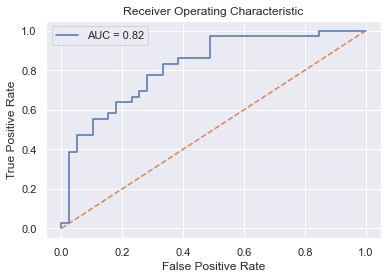

In [124]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label="malignant")

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');


from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred, labels=["benign", "malignant"])


"""
print(y_test)
print(y_pred)"""

In [125]:
confusion_matrix(y_test, y_pred, labels=["benign", "malignant"])


array([[26, 13],
       [ 7, 29]], dtype=int64)

In [126]:
y=[int(x=="malignant") for x in y_test]
z=[int(x=="malignant") for x in y_pred]
print("svm square error : ")
sklearn.metrics.mean_squared_error(y, z)

svm square error : 


0.26666666666666666

In [121]:
from sklearn.ensemble import RandomForestClassifier
# create the model - Random Forests
clf  = RandomForestClassifier(n_estimators=100)

# fit the training data to the model
Classifier = clf.fit(X_train, y_train)

#print(clf.fit(trainDataGlobal, trainLabelsGlobal))

clf_pred = clf.predict(X_test)
#clf_pred = clf.predict(global_feature.reshape(1,-1))[0]
print(classification_report(y_test,clf_pred))
#print(confusion_matrix(trainLabelsGlobal,clf_pred))
accuracy = accuracy_score(y_test, clf_pred)

print('Model accuracy is: ', accuracy)
#print(clf.predict(trainDataGlobal))

#print(clf.predict(global_feature.reshape(1,-1))[0])

confusion_matrix(y_test, clf_pred, labels=["benign", "malignant"])






              precision    recall  f1-score   support

      benign       0.78      0.64      0.70        39
   malignant       0.67      0.81      0.73        36

    accuracy                           0.72        75
   macro avg       0.73      0.72      0.72        75
weighted avg       0.73      0.72      0.72        75

Model accuracy is:  0.72


array([[25, 14],
       [ 7, 29]], dtype=int64)

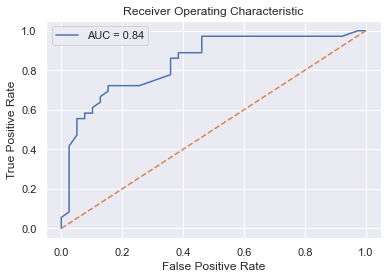

In [122]:
# predict probabilities for X_test using predict_proba
probabilities = Classifier.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label="malignant")

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');


In [123]:
import sklearn
y=[int(x=="malignant") for x in y_test]
z=[int(x=="malignant") for x in clf_pred]
print("random forest square error : ")
sklearn.metrics.mean_squared_error(y, z)


random forest square error : 


0.28

In [127]:
folder_dir = 'ISIC_2018_TEST/train/Benign'
thisdict={}
for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            preprocessing(folder_dir+'/'+img_id)
            
folder_dir = 'ISIC_2018_TEST/train/Malignant'
thisdict={}
for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            preprocessing(folder_dir+'/'+img_id)
            
folder_dir = 'ISIC_2018_TEST/val/Malignant'
thisdict={}
for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            preprocessing(folder_dir+'/'+img_id)

folder_dir = 'ISIC_2018_TEST/val/Benign'
thisdict={}
for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            preprocessing(folder_dir+'/'+img_id)

            
            
folder_dir = 'ISIC_2018_TEST'
thisdict={}
for img_id in os.listdir(folder_dir):
        if (img_id.endswith(".JPG")):
            preprocessing(folder_dir+'/'+img_id)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0